In [1]:
import pandas as pd
import yaml
import torch
from model import YNet
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from utils.dataloader import SceneDataset, scene_collate
from utils.preprocessing import create_images_dict
from utils.image_utils import (
    resize,
    pad,
    preprocess_image_for_segmentation,
    create_dist_mat,
)
from predict import predict
from mt import (
    flip_in_bounds,
    calculate_distances,
    calculate_displacement,
    calculate_displacement_mean,
    z_score,
    flip_ud_reproj,
    flip_lr_reproj,
    resize_reproj,
    rotate_image_and_trajectory,
    rotate_reproj,
    random_class_change,
    segmentation_class_map,
)
import scipy.special

import itertools
import json

In [2]:
%load_ext autoreload
%autoreload 2

#### Some hyperparameters and settings

In [3]:
## Longterm Prediction Setting
# CONFIG_FILE_PATH = 'config/sdd_longterm.yaml'  # yaml config file containing all the hyperparameters
# DATASET_NAME = 'sdd'

# TEST_DATA_PATH = 'data/SDD/test_longterm.pkl'
# TEST_IMAGE_PATH = 'data/SDD/test'
# OBS_LEN = 5  # in timesteps
# PRED_LEN = 30  # in timesteps
# NUM_GOALS = 20  # K_e
# NUM_TRAJ = 5  # K_a

## Shortterm Prediction Setting
CONFIG_FILE_PATH = (
    "config/sdd_trajnet.yaml"  # yaml config file containing all the hyperparameters
)
DATASET_NAME = "sdd"

TEST_DATA_PATH = "data/SDD/test_trajnet.pkl"
TEST_IMAGE_PATH = "data/SDD/test"  # only needed for YNet, PECNet ignores this value
OBS_LEN = 8  # in timesteps
PRED_LEN = 12  # in timesteps
NUM_GOALS = 20  # K_e
NUM_TRAJ = 1  # K_a

## General Settings
ROUNDS = 3  # Y-net is stochastic. How often to evaluate the whole dataset
BATCH_SIZE = 8

## Testing Settings
ROUNDS_VARIATION = 8  # N
RESIZE_PARAMS = (0.2, 0.3)
ROTATION_PARAMS = (90, 180, 270)

#### Load config file and print hyperparameters

In [4]:
with open(CONFIG_FILE_PATH) as file:
    params = yaml.load(file, Loader=yaml.FullLoader)
experiment_name = CONFIG_FILE_PATH.split(".yaml")[0].split("config/")[1]
params

{'resize': 0.25,
 'batch_size': 8,
 'viz_epoch': 10,
 'learning_rate': 0.0001,
 'num_epochs': 300,
 'encoder_channels': [32, 32, 64, 64, 64],
 'decoder_channels': [64, 64, 64, 32, 32],
 'waypoints': [11],
 'temperature': 1.0,
 'segmentation_model_fp': 'segmentation_models/SDD_segmentation.pth',
 'semantic_classes': 6,
 'loss_scale': 1000,
 'kernlen': 31,
 'nsig': 4,
 'use_features_only': False,
 'unfreeze': 150,
 'use_TTST': True,
 'rel_threshold': 0.01,
 'use_CWS': False,
 'CWS_params': 'None'}

#### Load preprocessed Data

In [5]:
df_test = pd.read_pickle(TEST_DATA_PATH)

In [6]:
df_test.head()

frame  trackId       x      y  sceneId  metaId
0      0     28.0  1539.5  578.0  coupa_0       0
1     12     28.0  1484.5  576.0  coupa_0       0
2     24     28.0  1484.5  576.0  coupa_0       0
3     36     28.0  1459.5  571.0  coupa_0       0
4     48     28.0  1432.5  569.0  coupa_0       0

In [7]:
df_test.shape

(56580, 6)

#### Initiate model and load pretrained weights

In [8]:
ynet_model = YNet(obs_len=OBS_LEN, pred_len=PRED_LEN, params=params)

/home/helge/ai4ccam/htp/Human-Path-Prediction/ynet/.venv/lib/python3.8/site-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'segmentation_models_pytorch.encoders.resnet.ResNetEncoder' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/helge/ai4ccam/htp/Human-Path-Prediction/ynet/.venv/lib/python3.8/site-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'segmentation_models_pytorch.base.modules.Conv2dReLU' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/helge/ai4ccam/htp/Human-Path-Prediction/ynet/.venv/lib/python3.8/site-packages/torch/serialization.py:657: S

In [9]:
ynet_model.load(f"pretrained_models/{experiment_name}_weights.pt")

<All keys matched successfully>


In [10]:
# Preparation code from `model.evaluate`
device = None
dataset_name = DATASET_NAME
image_path = TEST_IMAGE_PATH
batch_size = BATCH_SIZE
rounds = (ROUNDS,)
num_goals = NUM_GOALS
num_traj = NUM_TRAJ

if device is None:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

obs_len = ynet_model.obs_len
pred_len = ynet_model.pred_len
total_len = pred_len + obs_len

print("Preprocess data")
dataset_name = dataset_name.lower()
if dataset_name == "sdd":
    image_file_name = "reference.jpg"
elif dataset_name == "ind":
    image_file_name = "reference.png"
elif dataset_name == "eth":
    image_file_name = "oracle.png"
else:
    raise ValueError(f"{dataset_name} dataset is not supported")

# ETH/UCY specific: Homography matrix is needed to convert pixel to world coordinates
if dataset_name == "eth":
    ynet_model.homo_mat = {}
    for scene in [
        "eth",
        "hotel",
        "students001",
        "students003",
        "uni_examples",
        "zara1",
        "zara2",
        "zara3",
    ]:
        ynet_model.homo_mat[scene] = torch.Tensor(
            np.loadtxt(f"data/eth_ucy/{scene}_H.txt")
        ).to(device)
    seg_mask = True
else:
    ynet_model.homo_mat = None
    seg_mask = False

test_images = create_images_dict(
    df_test, image_path=image_path, image_file=image_file_name
)
test_images_orig = create_images_dict(
    df_test, image_path=image_path, image_file=image_file_name
)
resize(test_images_orig, factor=params["resize"], seg_mask=seg_mask)

test_dataset = SceneDataset(df_test, resize=params["resize"], total_len=total_len)
test_loader = DataLoader(test_dataset, batch_size=1, collate_fn=scene_collate)

# Preprocess images, in particular resize, pad and normalize as semantic segmentation backbone requires
resize(test_images, factor=params["resize"], seg_mask=seg_mask)

# Size before padding, needed to extract segmentation map for manipulation
size_unpadded = {k: v.shape for k, v in test_images.items()}

pad(
    test_images, division_factor=ynet_model.division_factor
)  # make sure that image shape is divisible by 32, for UNet architecture
preprocess_image_for_segmentation(test_images, seg_mask=seg_mask)

model = ynet_model.model.to(device)

# Create template
size = int(4200 * params["resize"])

input_template = torch.Tensor(create_dist_mat(size=size)).to(device)


# Rescale preparation
rescale_mr = {}

for resize_param in RESIZE_PARAMS:
    test_images_r = create_images_dict(
        df_test, image_path=image_path, image_file=image_file_name
    )
    resize(test_images_r, factor=resize_param, seg_mask=seg_mask)

    size_unpadded_resized = {k: v.shape for k, v in test_images_r.items()}

    pad(test_images_r, division_factor=ynet_model.division_factor)
    preprocess_image_for_segmentation(test_images_r, seg_mask=seg_mask)
    rescale_mr[resize_param] = (test_images_r, size_unpadded_resized)

Preprocess data


Prepare Dataset: 100%|██████████| 17/17 [00:00<00:00, 363.00it/s]
/home/helge/ai4ccam/htp/Human-Path-Prediction/ynet/utils/dataloader.py:35: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(trajectories), meta, scene_list


In [11]:
for trajectory, meta, scene in test_loader:
    print(scene, len(trajectory))

coupa_0 323
coupa_1 235
gates_2 155
hyang_0 630
hyang_1 427
hyang_3 61
hyang_8 12
little_0 52
little_1 110
little_2 42
little_3 362
nexus_5 14
nexus_6 334
quad_0 10
quad_1 20
quad_2 30
quad_3 12


#### Evaluate model

In [12]:
model.eval()

scene_name = "little_1"


def get_scene(loader, scene_name):
    for trajectory, meta, scene in loader:
        if scene == scene_name:
            return trajectory, meta, scene


log = []

with torch.no_grad():
    trajectory, meta, scene = get_scene(test_loader, scene_name)

    # Get scene image and apply semantic segmentation
    scene_image = test_images[scene].to(device).unsqueeze(0)
    scene_image_segm = model.segmentation(scene_image)

    scene_image_segm_resized = {}
    for resize_param_f in RESIZE_PARAMS:
        (test_images_r, size_unpadded_resized) = rescale_mr[resize_param_f]
        scene_image_segm_resized[resize_param_f] = model.segmentation(
            test_images_r[scene].to(device).unsqueeze(0)
        )

    for input_traj_id in range(0, len(trajectory), batch_size):  # len(trajectory)
        gt_future = trajectory[input_traj_id : input_traj_id + batch_size, obs_len:]
        input_trajectory = trajectory[
            input_traj_id : input_traj_id + batch_size, :obs_len, :
        ]
        gt_goal = gt_future[:, -1:]

        source_results = []

        # TODO Instead of this variation we could measure the variation in the 20 trajs per goals (5)
        for _ in range(ROUNDS_VARIATION):
            # We measure multiple times to get an idea of the intra-model variation in the results
            # This will become the threshold for the MR evaluation
            r = predict(
                model=model,
                scene_image=scene_image_segm,
                input_trajectory=input_trajectory,
                waypoints=params["waypoints"],
                num_goals=num_goals,
                num_traj=num_traj,
                input_template=input_template,
                obs_len=obs_len,
                temperature=params["temperature"],
                rel_thresh=0.002,
                device=device,
                use_CWS=True if len(params["waypoints"]) > 1 else False,
                use_TTST=True,
                CWS_params=params["CWS_params"],
            )
            r = [s.cpu().numpy() for s in r]
            ade, fde = calculate_displacement(
                gt_goal,
                gt_future,
                r[1],
                r[2],
                resize=params["resize"],
            )
            ade_mean, fde_mean = calculate_displacement_mean(
                gt_goal,
                gt_future,
                r[1],
                r[2],
                resize=params["resize"],
            )

            source_results.append(r + [ade, fde, ade_mean, fde_mean])

        # Calculate the avg. Wasserstein distance between the predictions per input trajectory
        source_distances = np.zeros(
            (int(scipy.special.comb(ROUNDS_VARIATION, 2)), input_trajectory.shape[0])
        )

        for pix, (r1, r2) in enumerate(itertools.combinations(source_results, 2)):
            future_samples1 = r1[1]
            future_samples2 = r2[1]

            for trajix in range(input_trajectory.shape[0]):
                source_distances[pix, trajix] = calculate_distances(
                    future_samples1[:, trajix, ...], future_samples2[:, trajix, ...]
                )[0]

        # (batch_size,)
        src_dist_mean = np.mean(source_distances, axis=0)
        src_dist_std = np.std(source_distances, axis=0)

        # Pick source test case
        # Source test case is the input_trajectory + scene_image_segm from above

        # Create follow-up input
        scene_image_segm_f = scene_image_segm.detach().clone()
        input_trajectory_f = input_trajectory.detach().clone()

        # Actual manipulation

        # Flip U/D
        # scene_image_segm_f = flip_in_bounds(
        #     scene_image_segm,
        #     x=size_unpadded[scene][0],
        #     y=size_unpadded[scene][1],
        #     axis=2,
        # )
        # input_trajectory_f[:, :, 1] = (
        #     size_unpadded[scene][0] - input_trajectory_f[:, :, 1]
        # )

        # Flip L/R
        # scene_image_segm_f = flip_in_bounds(
        #     scene_image_segm,
        #     x=size_unpadded[scene][0],
        #     y=size_unpadded[scene][1],
        #     axis=3,
        # )
        # input_trajectory_f[:, :, 0] = (
        #     size_unpadded[scene][1] - input_trajectory_f[:, :, 0]
        # )

        # TODO Rotate -> do before segmentation
        # Params: [90, 180, 270]
        # rotation_param = ROTATION_PARAMS[1]
        # center_x = size_unpadded[scene][0] / 2
        # center_y = size_unpadded[scene][1] / 2
        # input_trajectory_f = rotate_around_point_torch(
        #     input_trajectory_f, degrees=rotation_param, origin=(center_x, center_y)
        # )
        # scene_image_segm_f = rotate_tensor(
        #     scene_image_segm, rotation_param, size_unpadded[scene]
        # )

        # Resize
        # resize_param_f = RESIZE_PARAMS[1]
        # input_trajectory_f = input_trajectory_f * resize_param_f / params["resize"]
        # scene_image_segm_f = scene_image_segm_resized[resize_param_f].detach().clone()

        # Revert: input_trajectory_f = input_trajectory_f * params["resize"] / resize_value
        # If instable, create dataset and reload original trajectories for resizing

        # Segmentation class change
        # scene_image_segm_f, cc_info = random_class_change(scene_image_segm)

        # Obstacle appearance

        # TODO Keep track of change expectation / output relation
        # Eq, Red, Inc, Avoid?

        (
            pred_traj_f,
            future_samples_f,
            waypoint_samples_f,
            pred_waypoint_map_sigmoid_f,
        ) = predict(
            model=model,
            scene_image=scene_image_segm_f,
            input_trajectory=input_trajectory_f,
            waypoints=params["waypoints"],
            num_goals=num_goals,
            num_traj=num_traj,
            input_template=input_template,
            obs_len=obs_len,
            temperature=params["temperature"],
            rel_thresh=0.002,
            device=device,
            use_CWS=True if len(params["waypoints"]) > 1 else False,
            use_TTST=True,
            CWS_params=params["CWS_params"],
        )

        input_trajectory = input_trajectory.cpu().numpy()
        input_trajectory_f = input_trajectory_f.cpu().numpy()
        scene_image_segm_f = scene_image_segm_f.cpu().numpy()
        pred_traj_f = pred_traj_f.cpu().numpy()
        future_samples_f = future_samples_f.cpu().numpy()
        waypoint_samples_f = waypoint_samples_f.cpu().numpy()
        pred_waypoint_map_sigmoid_f = pred_waypoint_map_sigmoid_f.cpu().numpy()

        ## Evaluation
        # Revert metamorphic transformation
        (
            input_trajectory_f_re,
            pred_traj_f_re,
            pred_waypoint_map_sigmoid_f_re,
            waypoint_samples_f_re,
            future_samples_f_re,
        ) = flip_ud_reproj(
            input_trajectory_f,
            pred_traj_f=pred_traj_f,
            pred_waypoint_map_sigmoid_f=pred_waypoint_map_sigmoid_f,
            waypoint_samples_f=waypoint_samples_f,
            future_samples_f=future_samples_f,
            size_unpadded=size_unpadded[scene],
        )

        # (
        #     input_trajectory_f_re,
        #     pred_traj_f_re,
        #     pred_waypoint_map_sigmoid_f_re,
        #     waypoint_samples_f_re,
        #     future_samples_f_re,
        # ) = flip_lr_reproj(
        #     input_trajectory_f,
        #     pred_traj_f=pred_traj_f,
        #     pred_waypoint_map_sigmoid_f=pred_waypoint_map_sigmoid_f,
        #     waypoint_samples_f=waypoint_samples_f,
        #     future_samples_f=future_samples_f,
        #     size_unpadded=size_unpadded[scene],
        # )

        # (
        #     input_trajectory_f_re,
        #     pred_traj_f_re,
        #     pred_waypoint_map_sigmoid_f_re,
        #     waypoint_samples_f_re,
        #     future_samples_f_re,
        # ) = resize_reproj(
        #     input_trajectory_f,
        #     pred_traj_f=pred_traj_f,
        #     pred_waypoint_map_sigmoid_f=pred_waypoint_map_sigmoid_f,
        #     waypoint_samples_f=waypoint_samples_f,
        #     future_samples_f=future_samples_f,
        #     resize_param_src=params["resize"],
        #     resize_param_f=resize_param_f,
        # )

        # (
        #     input_trajectory_f_re,
        #     pred_traj_f_re,
        #     pred_waypoint_map_sigmoid_f_re,
        #     waypoint_samples_f_re,
        #     future_samples_f_re,
        # ) = rotate_reproj(
        #     input_trajectory_f,
        #     pred_traj_f=pred_traj_f,
        #     pred_waypoint_map_sigmoid_f=pred_waypoint_map_sigmoid_f,
        #     waypoint_samples_f=waypoint_samples_f,
        #     future_samples_f=future_samples_f,
        #     size_unpadded=size_unpadded[scene],
        #     rotation=rotation_param,
        # )

        assert np.isclose(input_trajectory_f_re, input_trajectory).all(), (
            "Reprojected input doesn't match original input"
        )

        # Here, we can evaluate against all samples collected before

        # For reference, evaluate against ground-truth labels, because we have them
        # Not part of the actual MR which doesn't need labels
        ade_f, fde_f = calculate_displacement(
            gt_goal,
            gt_future,
            future_samples_f_re,
            waypoint_samples_f_re,
            resize=params["resize"],
        )
        ade_f_mean, fde_f_mean = calculate_displacement_mean(
            gt_goal,
            gt_future,
            future_samples_f_re,
            waypoint_samples_f_re,
            resize=params["resize"],
        )

        # TODO We can do follow-ups per source test case and still use the same acceptance criteria

        for input_idx in range(input_trajectory.shape[0]):
            for src_ix, src_result in enumerate(source_results):
                (
                    pred_traj,
                    future_samples,
                    waypoint_samples,
                    pred_waypoint_map_sigmoid,
                    ade,
                    fde,
                    ade_mean,
                    fde_mean,
                ) = src_result

                ade_wasserstein, ade_min_distance = calculate_distances(
                    trajectories1=future_samples_f_re[:, input_idx, ...],
                    trajectories2=future_samples[:, input_idx, ...],
                )
                fde_wasserstein, fde_min_distance = calculate_distances(
                    waypoint_samples_f_re[:, input_idx, -1, :],
                    waypoint_samples[:, input_idx, -1, :],
                )
                zsc, pval = z_score(
                    ade_wasserstein, src_dist_mean[input_idx], src_dist_std[input_idx]
                )

                log_entry = {
                    "mr": "flipud",
                    "scene": scene,
                    "input_traj_id": input_traj_id + input_idx,
                    "source_idx": src_ix,
                    "follow_idx": 0,
                    "num_sources": len(source_results),
                    "source_dist_mean": src_dist_mean[input_idx],
                    "source_dist_std": src_dist_std[input_idx],
                    "source_fde": fde[input_idx],
                    "source_ade": ade[input_idx],
                    "source_fde_mean": fde_mean[input_idx],
                    "source_ade_mean": ade_mean[input_idx],
                    "ade_wasserstein": ade_wasserstein,
                    "ade_min_distance": ade_min_distance,
                    "fde_wasserstein": fde_wasserstein,
                    "fde_min_distance": fde_min_distance,
                    "follow_fde": fde_f[input_idx],
                    "follow_ade": ade_f[input_idx],
                    "follow_fde_mean": fde_f_mean[input_idx],
                    "follow_ade_mean": ade_f_mean[input_idx],
                    "zscore": zsc,
                    "pvalue": pval,
                }
                log.append(log_entry)

            print(
                f"FDE: {fde.mean():.2f} | FDE_f: {fde_f.mean():.2f} | ADE: {ade.mean():.2f} | ADE_f: {ade_f.mean():.2f}"
            )

        break
        # pd.DataFrame.from_records(log).to_csv(f"{experiment_name}_flipud.csv", index=False)

AssertionError: Reprojected input doesn't match original input

In [15]:
from matplotlib.path import Path


def create_obstacle_mask(
    size, obstacle_min_y, obstacle_max_y, obstacle_min_x, obstacle_max_x
):
    """Create a binary mask for an circle-approximation of given size."""
    mask = np.zeros((size, size), dtype=bool)
    center = size // 2
    radius = size // 2

    # Create points for the corners
    angles = np.linspace(0, 2 * np.pi, 13)[
        :-1
    ]  # n points, excluding the last to close the shape
    points = np.array(
        [
            (center + radius * np.cos(angle), center + radius * np.sin(angle))
            for angle in angles
        ]
    ).astype(int)

    # Fill the obstacle
    path = Path(points)
    y, x = np.mgrid[0:size, 0:size]
    points = np.column_stack((x.ravel(), y.ravel()))
    mask = path.contains_points(points).reshape(size, size)

    # Calculate the actual region size
    region_height = obstacle_max_y - obstacle_min_y
    region_width = obstacle_max_x - obstacle_min_x

    # Resize the mask to match the actual region size
    if region_height != size or region_width != size:
        # Crop the mask to match the actual region size
        mask_start_y = (size - region_height) // 2 if region_height < size else 0
        mask_start_x = (size - region_width) // 2 if region_width < size else 0
        mask = mask[
            mask_start_y : mask_start_y + region_height,
            mask_start_x : mask_start_x + region_width,
        ]

    return mask


def add_obstacle(
    scene_image_segm,
    trajectory,
    distance: float = 0.5,
    obstacle_size: int = 100,
    obstacle_class: str = "structure",
):
    """
    Add an obstacle to the class labels at a specified distance in the (future) trajectory.

    Args:
        class_labels: numpy array of class labels
        trajectory: numpy array of trajectory points
    """
    assert obstacle_class in segmentation_class_map, (
        f"Invalid obstacle class: {obstacle_class}"
    )

    class_labels = scene_image_segm.argmax(dim=1)
    scene_image_segm_modified = scene_image_segm.detach().clone()
    print(scene_image_segm_modified.shape, trajectory.shape)

    num_points = len(trajectory)

    # Calculate the boundaries
    obstacle_center = trajectory[int(distance * num_points)]
    obstacle_min_x = max(int(obstacle_center[0] - obstacle_size // 2), 0)
    obstacle_max_x = min(
        int(obstacle_center[0] + obstacle_size // 2),
        scene_image_segm_modified.shape[-1],
    )
    obstacle_min_y = max(int(obstacle_center[1] - obstacle_size // 2), 0)
    obstacle_max_y = min(
        int(obstacle_center[1] + obstacle_size // 2),
        scene_image_segm_modified.shape[-2],
    )

    # Apply the octagonal mask
    obstacle_mask = create_obstacle_mask(
        obstacle_size, obstacle_min_y, obstacle_max_y, obstacle_min_x, obstacle_max_x
    )

    class_idx = segmentation_class_map[obstacle_class]
    print(obstacle_min_x, obstacle_max_x, obstacle_min_y, obstacle_max_y)
    print(
        scene_image_segm_modified[
            0, class_idx, obstacle_min_y:obstacle_max_y, obstacle_min_x:obstacle_max_x
        ].shape
    )

    scene_image_segm_modified[
        0, class_idx, obstacle_min_y:obstacle_max_y, obstacle_min_x:obstacle_max_x
    ][obstacle_mask] = 1
    full_mask = np.zeros(scene_image_segm_modified.shape[-2:])
    full_mask[obstacle_min_y:obstacle_max_y, obstacle_min_x:obstacle_max_x] = (
        obstacle_mask
    )
    return scene_image_segm_modified, full_mask


def check_intersection(traj, full_obstacle_mask):
    return full_obstacle_mask[traj[:, 1].astype(int), traj[:, 0].astype(int)].any()


idx = 0

seg, fm = add_obstacle(scene_image_segm, input_trajectory[idx])

torch.Size([1, 6, 512, 352]) (8, 2)
0 73 259 359
torch.Size([100, 73])


In [17]:
# for idx in
idx = 0
input_trajectory[idx].shape


(8, 2)

In [46]:
(
    pred_traj_f.shape,
    future_samples_f.shape,
    waypoint_samples_f.shape,
    pred_waypoint_map_sigmoid_f.shape,
)

((8, 12, 2), (20, 8, 12, 2), (20, 8, 1, 2), (8, 1, 512, 352))

In [58]:
.shape

(8, 3174)

In [61]:
(
    pred_waypoint_map_sigmoid_f[:, 0, mask.cpu().numpy()]
    / source_results[0][3][:, 0, mask.cpu().numpy()]
).mean()

1.0131196

In [66]:
from scipy import stats

stats.wilcoxon(
    pred_waypoint_map_sigmoid_f[:, 0, mask.cpu().numpy()].flatten(),
    source_results[0][3][:, 0, mask.cpu().numpy()].flatten(),
    alternative="greater",
)

WilcoxonResult(statistic=203676343.0, pvalue=1.0)

In [47]:
future_samples_f

array([[[[ 45.45757 , 305.41568 ],
         [ 50.320564, 305.30804 ],
         [ 55.29724 , 305.08154 ],
         ...,
         [ 87.55713 , 303.62643 ],
         [ 92.274666, 303.31247 ],
         [ 96.752075, 303.0212  ]],

        [[ 45.48219 , 304.84082 ],
         [ 50.483513, 305.13336 ],
         [ 55.620003, 305.24344 ],
         ...,
         [ 88.67823 , 305.36157 ],
         [ 93.37856 , 305.2049  ],
         [ 97.71967 , 304.99158 ]],

        [[146.92554 , 308.86115 ],
         [151.30081 , 309.28384 ],
         [155.57745 , 309.4706  ],
         ...,
         [182.64987 , 307.71692 ],
         [186.50961 , 307.37192 ],
         [189.90976 , 306.92902 ]],

        ...,

        [[248.60956 , 305.91974 ],
         [253.5364  , 306.21066 ],
         [258.34512 , 306.3582  ],
         ...,
         [289.81992 , 306.65695 ],
         [294.57175 , 306.7282  ],
         [298.54596 , 306.83377 ]],

        [[176.97607 , 291.9401  ],
         [172.38315 , 291.89264 ],
         [16

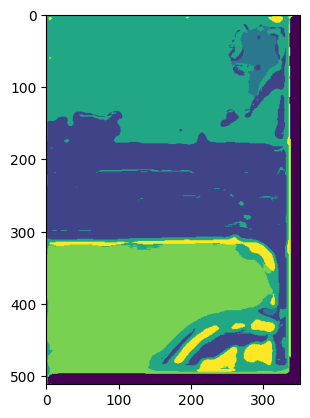

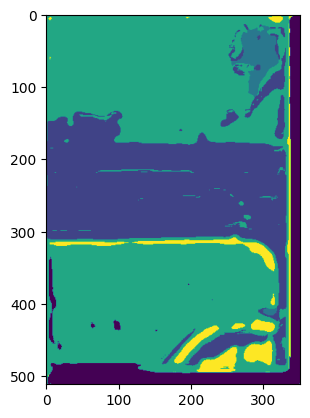

In [39]:
import matplotlib.pyplot as plt

plt.imshow(scene_image_segm.argmax(dim=1).squeeze().cpu().numpy())

plt.figure()
plt.imshow(scene_image_segm_f.argmax(dim=1).squeeze().cpu().numpy())

In [27]:
scene_image_segm.argmax(dim=1)

tensor([[[3, 3, 3,  ..., 0, 0, 0],
         [3, 3, 3,  ..., 0, 0, 0],
         [3, 3, 3,  ..., 0, 0, 0],
         ...,
         [3, 5, 0,  ..., 0, 0, 0],
         [3, 3, 0,  ..., 0, 0, 0],
         [3, 3, 3,  ..., 0, 3, 3]]], device='cuda:0')

In [14]:
pd.DataFrame.from_records(log)

mr     scene  input_traj_id  source_idx  follow_idx  num_sources  \
0   flipud  little_1              0           0           0            8   
1   flipud  little_1              0           1           0            8   
2   flipud  little_1              0           2           0            8   
3   flipud  little_1              0           3           0            8   
4   flipud  little_1              0           4           0            8   
..     ...       ...            ...         ...         ...          ...   
59  flipud  little_1              7           3           0            8   
60  flipud  little_1              7           4           0            8   
61  flipud  little_1              7           5           0            8   
62  flipud  little_1              7           6           0            8   
63  flipud  little_1              7           7           0            8   

    source_dist_mean  source_dist_std  source_fde  source_ade  ...  \
0          47.508796         0.697293   13.033476    6.396744  ...   
1          47.508796         0.697293    5.010062    7.974262  ...   
2          47.508796         0.697293    1.874695    6.203896  ...   
3          47.508796         0.697293   16.284887    6.305324  ...   
4          47.508796         0.697293   15.137017    8.029799  ...   
..               ...              ...         ...         ...  ...   
59         51.784303         0.686046   14.663622    7.412630  ...   
60         51.784303         0.686046   17.465122    7.941782  ...   
61         51.784303         0.686046   19.509821    9.325921  ...   
62         51.784303         0.686046   17.078545    7.941782  ...   
63         51.784303         0.686046   11.933863    5.974917  ...   

    ade_wasserstein  ade_min_distance  fde_wasserstein  fde_min_distance  \
0         46.849047         10.608618        24.295331          5.326250   
1         46.819282         10.347275        24.323656          5.079832   
2         48.551794          8.924289        25.182273          4.333583   
3         46.700987          9.872890        24.159841          4.919385   
4         46.780716          9.738367        24.252846          4.951545   
..              ...               ...              ...               ...   
59        54.095513         11.672132        28.062853          5.752631   
60        55.494074         12.956286        28.689995          6.623827   
61        55.022025         13.149083        28.595885          6.895985   
62        54.930634         12.127882        28.536395          6.439271   
63        55.669676         12.906804        28.834784          6.560771   

    follow_fde  follow_ade  follow_fde_mean  follow_ade_mean    zscore  \
0     5.052557    5.813107        77.605637        38.610847 -0.946159   
1     5.052557    5.813107        77.605637        38.610847 -0.988844   
2     5.052557    5.813107        77.605637        38.610847  1.495782   
3     5.052557    5.813107        77.605637        38.610847 -1.158493   
4     5.052557    5.813107        77.605637        38.610847 -1.044153   
..         ...         ...              ...              ...       ...   
59    8.718732    4.490407        79.418953        37.234974  3.368884   
60    8.718732    4.490407        79.418953        37.234974  5.407466   
61    8.718732    4.490407        79.418953        37.234974  4.719394   
62    8.718732    4.490407        79.418953        37.234974  4.586180   
63    8.718732    4.490407        79.418953        37.234974  5.663428   

          pvalue  
0   3.440677e-01  
1   3.227393e-01  
2   1.347106e-01  
3   2.466628e-01  
4   2.964145e-01  
..           ...  
59  7.547309e-04  
60  6.392270e-08  
61  2.365483e-06  
62  4.514292e-06  
63  1.483784e-08  

[64 rows x 22 columns]

In [15]:
input_trajectory[0], input_trajectory_f[0]

(array([[  7.25 , 309.875],
        [  8.875, 309.875],
        [ 12.5  , 309.875],
        [ 18.   , 309.875],
        [ 23.5  , 309.875],
        [ 29.   , 307.875],
        [ 35.   , 305.875],
        [ 40.5  , 305.875]], dtype=float32),
 array([[  7.25 , 176.125],
        [  8.875, 176.125],
        [ 12.5  , 176.125],
        [ 18.   , 176.125],
        [ 23.5  , 176.125],
        [ 29.   , 178.125],
        [ 35.   , 180.125],
        [ 40.5  , 180.125]], dtype=float32))

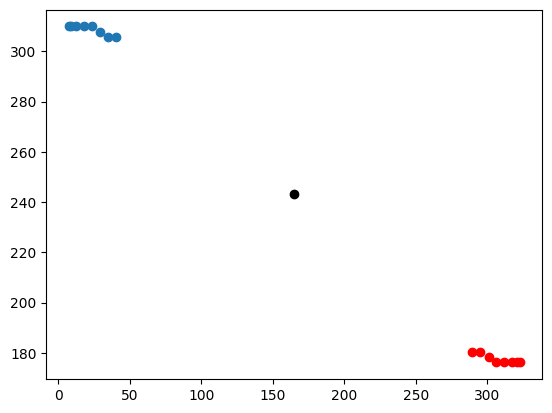

In [16]:
cx = size_unpadded[scene][1] / 2
cy = size_unpadded[scene][0] / 2

ipf = rotate_around_point_torch(
    torch.tensor(input_trajectory[0]), degrees=180, origin=(cx, cy)
)
ipf2 = rotate_around_point_torch(ipf, degrees=-180, origin=(cx, cy))
plt.scatter(input_trajectory[0][:, 0], input_trajectory[0][:, 1])
plt.scatter(cx, cy, c="black")
plt.scatter(ipf[:, 0], ipf[:, 1], c="red")
# plt.scatter(ipf2[:, 0], ipf2[:, 1], c="green")

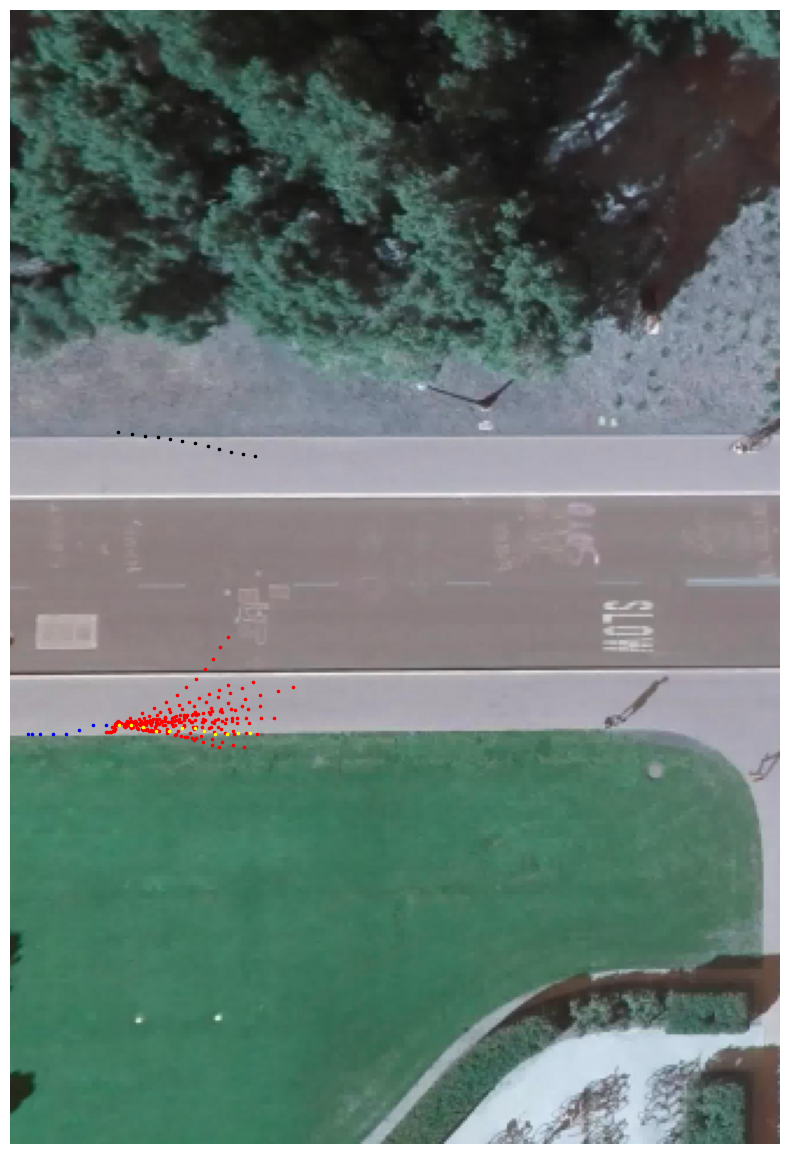

In [17]:
# For plotting, pick one trajectory
ix = 0
inp = input_trajectory[ix]
pred = pred_traj[ix]
truth = gt_future[ix]
heatmap = pred_waypoint_map_sigmoid[ix, -1]

inp_f = input_trajectory_f_re[ix]
pred_f = pred_traj_f[ix]
# truth_f = gt_future[ix]
heatmap_f = pred_waypoint_map_sigmoid_f_re[ix, -1]

plt.figure(figsize=(8, 12))

# plt.imshow(np.flip(test_images_orig[scene_name], axis=1))
plt.imshow(test_images_orig[scene_name])
# plt.imshow(
#     heatmap,
#     cmap="bwr",
#     interpolation="nearest",
#     alpha=0.2,
# )

# plt.imshow(
#     heatmap_f,
#     cmap="PRGn",
#     interpolation="nearest",
#     alpha=0.2,
# )

scatter_size = 2.5

plt.scatter(inp[:, 0], inp[:, 1], c="blue", s=scatter_size, label="Past Trajectory")

plt.scatter(
    future_samples[:, ix, :, 0],
    future_samples[:, ix, :, 1],
    c="red",
    s=scatter_size,
    label="Predicted Trajectories",
    # marker=">",
    # alpha=0.5,
)
# plt.scatter(
#     future_samples_f_re[:, ix, :, 0],
#     future_samples_f_re[:, ix, :, 1],
#     c="green",
#     s=scatter_size,
#     label="Follow-Up (alt)",
#     # marker="x",
#     alpha=0.5,
# )

# plt.scatter(pred[:, 0], pred[:, 1], c="red", s=scatter_size, label="Source")
plt.scatter(truth[:, 0], truth[:, 1], c="yellow", s=scatter_size, label="Truth")


plt.scatter(pred_f[:, 0], pred_f[:, 1], c="black", s=scatter_size, label="Follow-Up")
# plt.scatter(
#     inp_f[:, 0],
#     inp_f[:, 1],
#     c="purple",
#     s=scatter_size,
# )
# plt.legend()
plt.axis("off")
# plt.scatter(
#     waypoint_samples[:, ix, -1:, 0],
#     waypoint_samples[:, ix, -1:, 1],
#     c="brown",
#     s=5,
# )

# plt.scatter(
#     waypoint_samples_ff[:, ix, -1:, 0],
#     waypoint_samples_ff[:, ix, -1:, 1],
#     c="purple",
#     s=5,
# )
plt.tight_layout()
# plt.savefig("traj-inp-out.pdf", dpi=400, bbox_inches="tight")
fig = plt.gcf()
fig.canvas.draw()
data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))

In [18]:
import cv2

res = cv2.resize(data, dsize=(800, 600))
cv2.imwrite("input-output-example.png", cv2.cvtColor(res, cv2.COLOR_RGB2BGR))

True

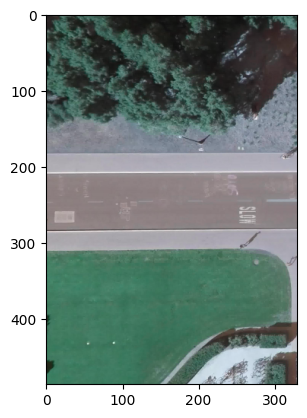

In [19]:
plt.imshow(test_images_orig[scene_name])

In [99]:
def rotate_image_and_trajectory2(image, trajectory, degrees=90):
    """
    Rotates image tensor (b,c,h,w) and trajectory (t,l,2) counter-clockwise by k * 90 degrees around the image center

    Args:
        image: torch.Tensor of shape (b,c,h,w) - batch of images
        trajectory: torch.Tensor of shape (t,l,2) - trajectory coordinates
        degrees: int - number of degrees to rotate

    Returns:
        rotated_image: torch.Tensor - rotated image
        rotated_traj: torch.Tensor - rotated trajectory
    """
    import torch
    import numpy as np

    image = image.clone()
    trajectory = trajectory.clone()

    # Validate degrees
    k = degrees // 90
    k = k % 4  # Normalize to 0-3 range
    if k == 0:
        return image, trajectory

    # Get image dimensions
    h, w = image.shape[-2:]

    # Create rotation matrix
    theta = -k * np.pi / 2  # Negative for counter-clockwise rotation
    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)
    R = torch.tensor(
        [[cos_theta, -sin_theta], [sin_theta, cos_theta]],
        dtype=trajectory.dtype,
        device=trajectory.device,
    )

    # Center coordinates at image center, rotate, then translate back
    t, l, _ = trajectory.shape
    image_center = torch.tensor(
        [w / 2, h / 2], dtype=trajectory.dtype, device=trajectory.device
    )
    centered_traj = trajectory - image_center

    # Reshape to (t*l, 2) for batch rotation
    flat_traj = centered_traj.reshape(-1, 2)
    rotated_flat = torch.mm(flat_traj, R.t())
    rotated_traj = rotated_flat.reshape(t, l, 2)

    # Translate back based on rotated image dimensions
    if k % 2 == 1:  # 90° or 270° - dimensions are swapped
        rotated_traj = rotated_traj + torch.tensor(
            [h / 2, w / 2], dtype=trajectory.dtype, device=trajectory.device
        )
    else:  # 180° - dimensions stay the same
        rotated_traj = rotated_traj + image_center

    # Rotate image tensor around its center
    rotated_image = torch.rot90(image, k, dims=[-2, -1])

    return rotated_image, rotated_traj


torch.Size([8, 8, 2])
(486, 330, 3) (486, 330, 3)
torch.Size([486, 330]) torch.Size([3, 486, 330]) tensor([243., 165.])
torch.Size([3, 486, 330]) torch.Size([486, 330, 3]) torch.Size([8, 8, 2])
torch.Size([486, 330]) torch.Size([3, 486, 330]) tensor([243., 165.])
torch.Size([3, 486, 330]) torch.Size([330, 486, 3]) torch.Size([8, 8, 2])
torch.Size([486, 330]) torch.Size([3, 486, 330]) tensor([243., 165.])
torch.Size([3, 486, 330]) torch.Size([486, 330, 3]) torch.Size([8, 8, 2])
torch.Size([486, 330]) torch.Size([3, 486, 330]) tensor([243., 165.])
torch.Size([3, 486, 330]) torch.Size([330, 486, 3]) torch.Size([8, 8, 2])


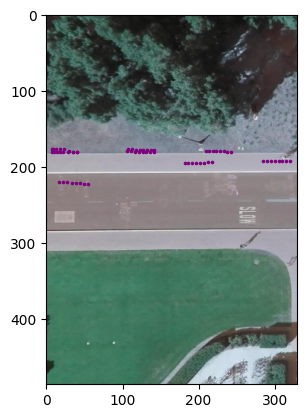

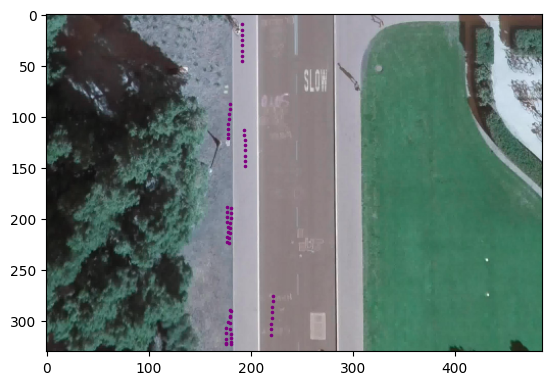

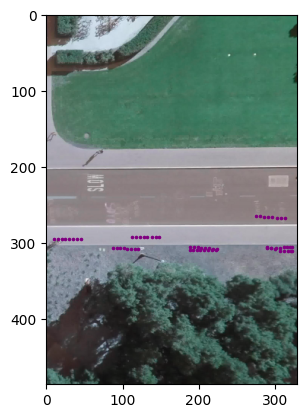

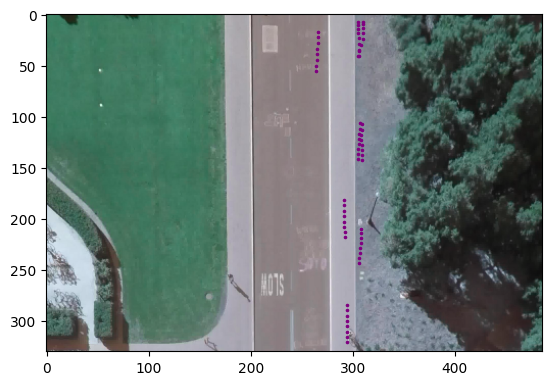

In [101]:
from mt import rotate_image_and_trajectory

inp_f = torch.from_numpy(input_trajectory_f)
pred_f = pred_traj_f[ix]
# truth_f = gt_future[ix]
heatmap_f = pred_waypoint_map_sigmoid_f[ix, -1]
print(inp_f.shape)
print(size_unpadded[scene], test_images_orig[scene_name].shape)
inpimg = torch.from_numpy(test_images_orig[scene_name]).permute(2, 0, 1)

rotimg, rottraj = rotate_image_and_trajectory(inpimg, inp_f, degrees=0)
rotimg = rotimg.permute(1, 2, 0)
print(inpimg.shape, rotimg.shape, rottraj.shape)
plt.imshow(rotimg)
plt.scatter(
    rottraj[..., 0],
    rottraj[..., 1],
    c="purple",
    s=scatter_size,
)

plt.figure()
rotimg, rottraj = rotate_image_and_trajectory(inpimg, inp_f, degrees=90)
rotimg = rotimg.permute(1, 2, 0)
print(inpimg.shape, rotimg.shape, rottraj.shape)
plt.imshow(rotimg)
plt.scatter(
    rottraj[..., 0],
    rottraj[..., 1],
    c="purple",
    s=scatter_size,
)

plt.figure()
rotimg, rottraj = rotate_image_and_trajectory(inpimg, inp_f, degrees=180)
rotimg = rotimg.permute(1, 2, 0)
print(inpimg.shape, rotimg.shape, rottraj.shape)
plt.imshow(rotimg)
plt.scatter(
    rottraj[..., 0],
    rottraj[..., 1],
    c="purple",
    s=scatter_size,
)

plt.figure()
rotimg, rottraj = rotate_image_and_trajectory(inpimg, inp_f, degrees=270)
rotimg = rotimg.permute(1, 2, 0)
print(inpimg.shape, rotimg.shape, rottraj.shape)
plt.imshow(rotimg)
plt.scatter(
    rottraj[..., 0],
    rottraj[..., 1],
    c="purple",
    s=scatter_size,
)

In [110]:
## Simple test of rotation functions

inp_f = torch.from_numpy(input_trajectory_f)
pred_f = pred_traj_f[ix]
# truth_f = gt_future[ix]
heatmap_f = pred_waypoint_map_sigmoid_f[ix, -1]

inpimg = torch.from_numpy(test_images_orig[scene_name]).permute(2, 0, 1)

rotimg, rottraj = rotate_image_and_trajectory(inpimg, inp_f, degrees=0)

for _ in range(4):
    rotimg, rottraj = rotate_image_and_trajectory(rotimg, rottraj, degrees=90)

assert torch.all(inpimg == rotimg)
assert torch.all(inp_f == rottraj)

rotimg, rottraj = rotate_image_and_trajectory(inpimg, inp_f, degrees=0)

for _ in range(2):
    rotimg, rottraj = rotate_image_and_trajectory(rotimg, rottraj, degrees=180)

assert torch.all(inpimg == rotimg)
assert torch.all(inp_f == rottraj)

# 270 == 3*90
rotimg, rottraj = rotate_image_and_trajectory(inpimg, inp_f, degrees=0)

for _ in range(3):
    rotimg, rottraj = rotate_image_and_trajectory(rotimg, rottraj, degrees=90)

rotimg2, rottraj2 = rotate_image_and_trajectory(inpimg, inp_f, degrees=270)
assert torch.all(rotimg2 == rotimg)
assert torch.all(rottraj2 == rottraj)

rotimg, rottraj = rotate_image_and_trajectory(inpimg, inp_f, degrees=90)
rotimg2, rottraj2 = rotate_image_and_trajectory(rotimg, rottraj, degrees=-90)
print(inpimg.shape, rotimg2.shape, inp_f.shape, rottraj2.shape)
assert torch.all(rotimg2 == inpimg)
assert torch.all(rottraj2 == inp_f)

torch.Size([486, 330]) torch.Size([3, 486, 330]) tensor([243., 165.])
torch.Size([486, 330]) torch.Size([3, 486, 330]) tensor([243., 165.])
torch.Size([330, 486]) torch.Size([3, 330, 486]) tensor([165., 243.])
torch.Size([486, 330]) torch.Size([3, 486, 330]) tensor([243., 165.])
torch.Size([330, 486]) torch.Size([3, 330, 486]) tensor([165., 243.])
torch.Size([486, 330]) torch.Size([3, 486, 330]) tensor([243., 165.])
torch.Size([486, 330]) torch.Size([3, 486, 330]) tensor([243., 165.])
torch.Size([486, 330]) torch.Size([3, 486, 330]) tensor([243., 165.])
torch.Size([486, 330]) torch.Size([3, 486, 330]) tensor([243., 165.])
torch.Size([486, 330]) torch.Size([3, 486, 330]) tensor([243., 165.])
torch.Size([330, 486]) torch.Size([3, 330, 486]) tensor([165., 243.])
torch.Size([486, 330]) torch.Size([3, 486, 330]) tensor([243., 165.])
torch.Size([486, 330]) torch.Size([3, 486, 330]) tensor([243., 165.])
torch.Size([486, 330]) torch.Size([3, 486, 330]) tensor([243., 165.])
torch.Size([330, 486

In [112]:
inp_f - rottraj2

tensor([[[0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],


: 

/tmp/ipykernel_427796/3741601780.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10', np.max(class_labels) + 1)  # 'tab10' colormap has 10 distinct colors


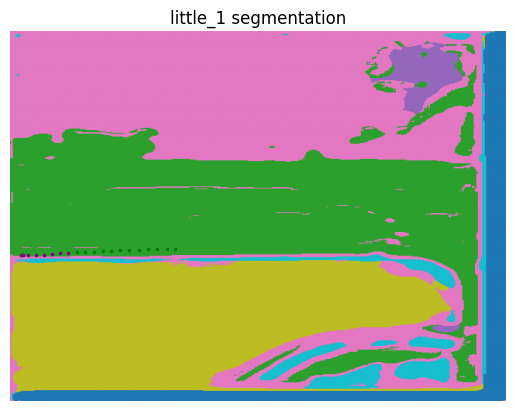

In [86]:
# .shape
# plt.imshow(scene_image_segm)
data = np.transpose(scene_image_segm.cpu().numpy().argmax(axis=1), (1, 2, 0))
class_labels = np.squeeze(data)

# Create a color map with distinct colors for each class
cmap = plt.cm.get_cmap(
    "tab10", np.max(class_labels) + 1
)  # 'tab10' colormap has 10 distinct colors

# TODO We need the class labels for a mapping

# Convert class labels to RGB colors using the colormap
colored_image = cmap(class_labels / np.max(class_labels))
plt.imshow(colored_image, aspect="auto")
plt.title(f"{scene} segmentation")
plt.axis("off")
# plt.legend()
# plt.show()

plt.scatter(
    pred[:, 0],
    pred[:, 1],
    c="green",
    s=scatter_size,
)
plt.scatter(
    inp[:, 0],
    inp[:, 1],
    c="purple",
    s=scatter_size,
)

243.0 165.0 [[478.75      20.124985]
 [477.125     20.124985]
 [473.5       20.124985]
 [468.        20.124985]
 [462.5       20.124985]
 [457.        22.124985]
 [451.        24.124985]
 [445.5       24.124985]]


/tmp/ipykernel_427796/3425724676.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10', np.max(class_labels) + 1)  # 'tab10' colormap has 10 distinct colors


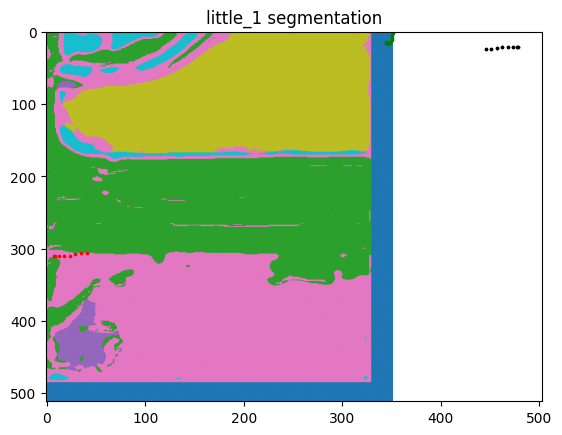

In [87]:
# .shape
# plt.imshow(scene_image_segm)

center_x = size_unpadded[scene][0] / 2
center_y = size_unpadded[scene][1] / 2
inp_f2 = (
    rotate_around_point_torch(
        torch.from_numpy(input_trajectory[0]),
        degrees=rotation_param,
        origin=(center_x, center_y),
    )
    .cpu()
    .numpy()
)

print(center_x, center_y, inp_f2)

data = np.transpose(scene_image_segm_f.argmax(axis=1), (1, 2, 0))
class_labels = np.squeeze(data)

# Create a color map with distinct colors for each class
cmap = plt.cm.get_cmap(
    "tab10", np.max(class_labels) + 1
)  # 'tab10' colormap has 10 distinct colors

# TODO We need the class labels for a mapping

# Convert class labels to RGB colors using the colormap
colored_image = cmap(class_labels / np.max(class_labels))
plt.imshow(colored_image, aspect="auto")
plt.title(f"{scene} segmentation")
# plt.axis('off')
# plt.legend()
# plt.show()

plt.scatter(
    pred_f[:, 0],
    pred_f[:, 1],
    c="green",
    s=scatter_size,
)
plt.scatter(
    inp[:, 0],
    inp[:, 1],
    c="red",
    s=scatter_size,
)
plt.scatter(
    inp_f[:, 0],
    inp_f[:, 1],
    c="purple",
    s=scatter_size,
)
plt.scatter(
    inp_f2[:, 0],
    inp_f2[:, 1],
    c="black",
    s=scatter_size,
)

/tmp/ipykernel_335763/2420222151.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10', np.max(class_labels) + 1)  # 'tab10' colormap has 10 distinct colors


(-0.5, 351.5, 511.5, -0.5)

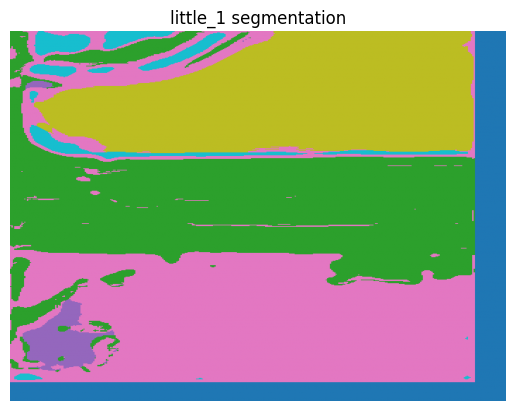

In [55]:
# .shape
# plt.imshow(scene_image_segm)
import torch


plt.figure()
data = np.transpose(
    rotate_tensor(scene_image_segm, 180, size_unpadded[scene])
    .argmax(axis=1)
    .cpu()
    .numpy(),
    (1, 2, 0),
)
class_labels = np.squeeze(data)

# Create a color map with distinct colors for each class
cmap = plt.cm.get_cmap(
    "tab10", np.max(class_labels) + 1
)  # 'tab10' colormap has 10 distinct colors

# TODO We need the class labels for a mapping

# Convert class labels to RGB colors using the colormap
colored_image = cmap(class_labels / np.max(class_labels))
plt.imshow(colored_image, aspect="auto")
plt.title(f"{scene} segmentation")
plt.axis("off")
# plt.legend()
# plt.show()

In [57]:
40 not in {30, 100, 10}

True

(-0.5, 351.5, 511.5, -0.5)

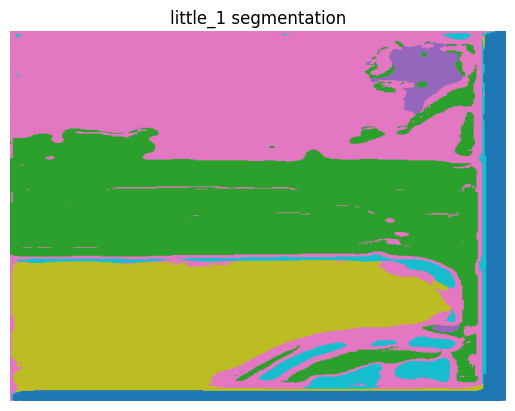

In [31]:
data = np.transpose(scene_image_segm.argmax(axis=1).cpu().numpy(), (1, 2, 0))
class_labels = np.squeeze(data)

# Create a color map with distinct colors for each class
cmap = plt.cm.get_cmap(
    "tab10", np.max(class_labels) + 1
)  # 'tab10' colormap has 10 distinct colors

# TODO We need the class labels for a mapping

# Convert class labels to RGB colors using the colormap
colored_image = cmap(class_labels / np.max(class_labels))
plt.imshow(colored_image, aspect="auto")
plt.title(f"{scene} segmentation")
plt.axis("off")

In [1]:
import imageio.v3 as iio
import matplotlib.patches as mpatches

data = iio.imread("data/SDD_semantic_maps/test_masks/little_1_mask.png")
# data = iio.imread('data/SDD_semantic_maps/test_masks/coupa_1_mask.png')
print(data.shape)
class_labels = np.squeeze(data)

num_labels = np.max(class_labels) + 1

# Create a color map with distinct colors for each class
cmap = plt.cm.get_cmap(
    "tab10", np.max(class_labels) + 1
)  # 'tab10' colormap has 10 distinct colors

# Convert class labels to RGB colors using the colormap
colored_image = cmap(class_labels / np.max(class_labels))

colors = [cmap(i / (num_labels - 1)) for i in range(num_labels)]

plt.imshow(colored_image, aspect="auto")
# plt.title(f"{scene} segmentation")

# 0 - background (blue)
# 1 - pavement (green)
# 2 - road (purple)
# 3 - structure (pink)
# 4 - terrain (yellow)
# 5 - tree (turkis/teal)

labels = ["Background", "Pavement", "Road", "Structure", "Terrain", "Tree"]
patches = [
    mpatches.Patch(color=color, label=label) for color, label in zip(colors, labels)
]

plt.legend(handles=patches, loc="upper right")

plt.axis("off")
plt.tight_layout()
plt.savefig("segmentation.pdf", dpi=400, bbox_inches="tight")
# plt.show()

ModuleNotFoundError: No module named 'imageio'

In [23]:
(
    input_trajectory.shape,
    pred_traj.shape,
    gt_future.shape,
    pred_waypoint_map_sigmoid.shape,
)

(torch.Size([6, 5, 2]),
 torch.Size([6, 30, 2]),
 torch.Size([6, 30, 2]),
 torch.Size([6, 2, 512, 352]))

In [24]:
# predict_and_evaluate(
#     model,
#     test_loader,
#     test_images,
#     num_goals,
#     num_traj,
#     obs_len=obs_len,
#     batch_size=batch_size,
#     device=device,
#     input_template=input_template,
#     waypoints=params["waypoints"],
#     resize=params["resize"],
#     temperature=params["temperature"],
#     use_TTST=True,
#     use_CWS=True if len(params["waypoints"]) > 1 else False,
#     rel_thresh=params["rel_threshold"],
#     CWS_params=params["CWS_params"],
#     dataset_name=dataset_name,
#     homo_mat=ynet_model.homo_mat,
#     mode="test",
# )

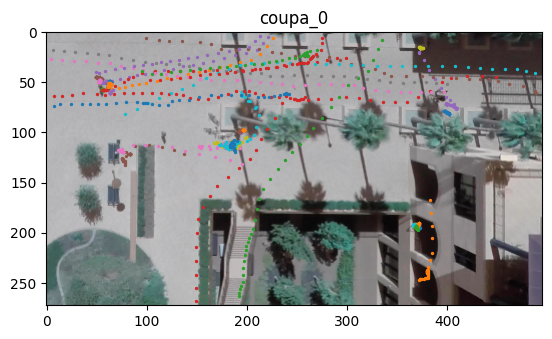

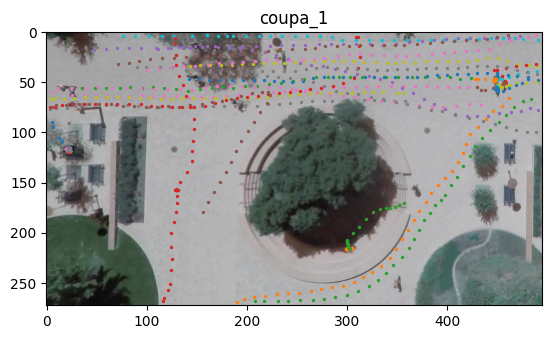

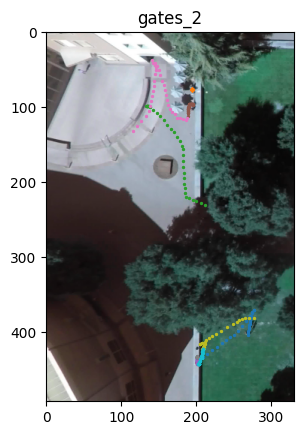

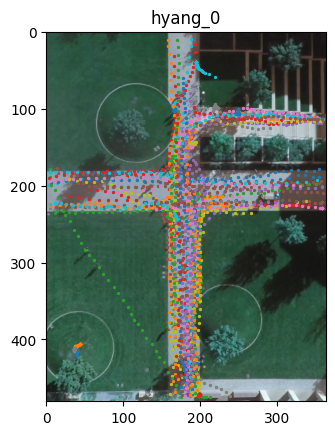

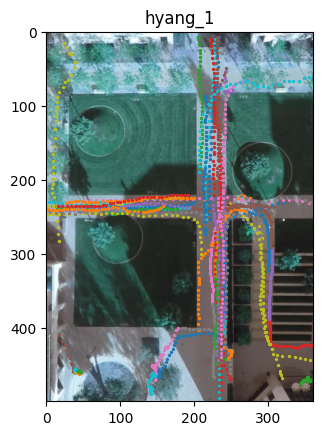

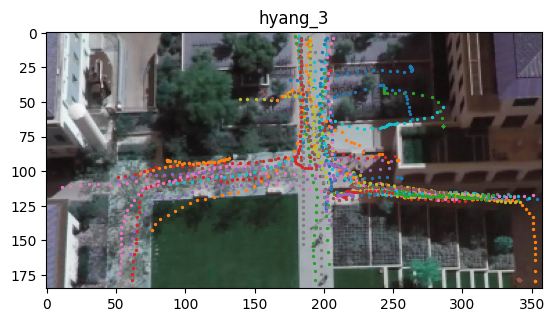

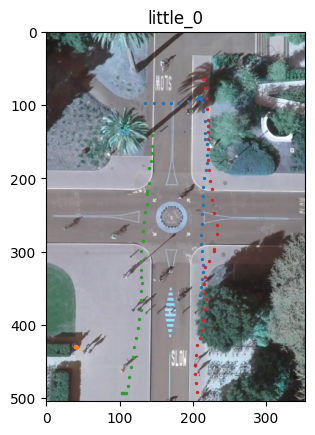

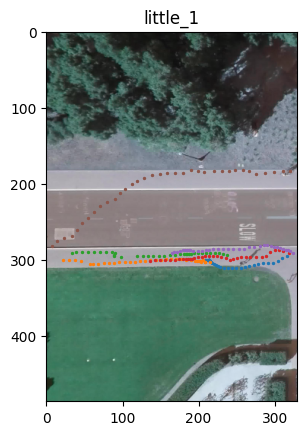

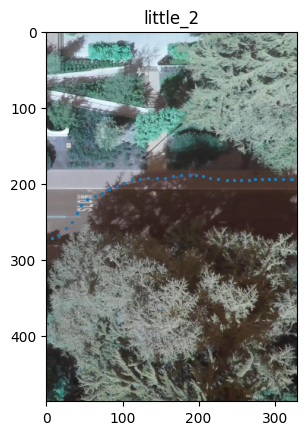

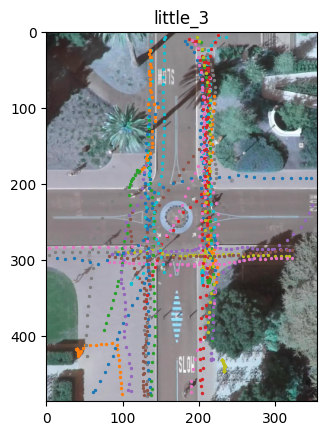

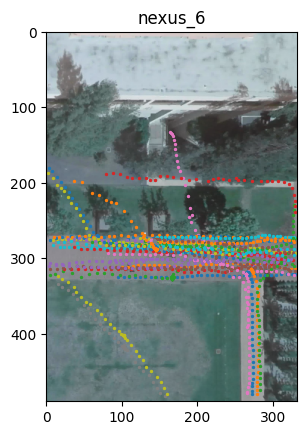

In [25]:
for trajectory, meta, scene in test_loader:
    # print(meta, scene)
    plt.figure()
    plt.title(scene)
    plt.imshow(test_images_orig[scene])

    for t in trajectory:
        plt.scatter(t[:, 0], t[:, 1], s=2)
        # break